# Import the required library
from IPython.display import display, Javascript

# Define a JavaScript function to keep the Colab session alive by clicking 'Reconnect' or 'Dismiss'
def keep_colab_alive():
    js_code = '''
    function ClickConnect(){
        console.log("Attempting to stay connected...");
        var buttons = document.querySelectorAll("colab-dialog paper-button");
        buttons.forEach(function(btn) {
            if (btn.innerText.trim() === "Dismiss" || btn.innerText.trim() === "Reconnect") {
                btn.click();
                console.log("Clicked " + btn.innerText);
            }
        });
    }
    setInterval(ClickConnect, 30000);  // Reduced interval to 30 seconds for faster checks
    '''
    display(Javascript(js_code))

# Call the function to keep the session active
keep_colab_alive()

In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam, SGD, Adagrad, RMSprop
from sklearn.impute import SimpleImputer
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Attention, BatchNormalization, LayerNormalization, GRU, GaussianNoise, Conv1D, MaxPooling1D
from tensorflow.keras.losses import BinaryCrossentropy
from keras.layers import Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import mean_absolute_error, mean_squared_error
from keras.models import Sequential
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, BatchNormalization, TimeDistributed
from tensorflow.keras import regularizers
from keras.regularizers import l2
from tensorflow.keras.regularizers import L1L2
import math
from collections import Counter
from keras.layers import BatchNormalization
import pandas as pd

In [2]:
path = 'combined_output_55.txt'

In [3]:
# Attempt with space as delimiter
dataframe = pd.read_csv(path, sep=' ', header=None)

# Attempt with multiple spaces as delimiter (regex)
# dataframe = pd.read_csv(path, sep=r'\\s+', header=None)

In [4]:
print("First few rows of the correctly parsed dataset:")
print(dataframe.head())

First few rows of the correctly parsed dataset:
      0         1         2         3         4         5         6      \
0  0.154990  0.698085  0.762580  0.785502  0.807545  0.803495  0.751685   
1  0.551698  0.407886  0.393065  0.368134  0.333782  0.303575  0.252833   

      7         8         9      ...     83414     83415     83416     83417  \
0  0.687817  0.608689  0.528022  ...  0.097560  0.103023  0.143749  0.159167   
1  0.191289  0.137783  0.094137  ... -0.511192 -0.430117 -0.227399 -0.129054   

      83418     83419     83420     83421     83422     83423  
0  0.170094  0.188337  0.240179  0.238075  0.244072  0.216315  
1 -0.073162  0.119320  0.319087  0.705746  0.818849  0.883533  

[2 rows x 83424 columns]


In [5]:
# Check for missing values
print("\nChecking for missing values:")
missing_values = dataframe.isnull().sum().sum()
if missing_values > 0:
    print(f"Total missing values: {missing_values}")
    print("Columns with missing values:")
    print(dataframe.isnull().sum()[dataframe.isnull().sum() > 0])
else:
    print("\nNo missing values found.")


Checking for missing values:

No missing values found.


In [6]:
print("\nSummary statistics of the dataset:")
print(dataframe.describe())


Summary statistics of the dataset:
          0         1         2         3         4         5         6      \
count  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000  2.000000   
mean   0.353344  0.552985  0.577823  0.576818  0.570664  0.553535  0.502259   
std    0.280515  0.205202  0.261287  0.295124  0.335001  0.353496  0.352741   
min    0.154990  0.407886  0.393065  0.368134  0.333782  0.303575  0.252833   
25%    0.254167  0.480436  0.485444  0.472476  0.452223  0.428555  0.377546   
50%    0.353344  0.552985  0.577823  0.576818  0.570664  0.553535  0.502259   
75%    0.452521  0.625535  0.670202  0.681160  0.689104  0.678515  0.626972   
max    0.551698  0.698085  0.762580  0.785502  0.807545  0.803495  0.751685   

          7         8         9      ...     83414     83415     83416  \
count  2.000000  2.000000  2.000000  ...  2.000000  2.000000  2.000000   
mean   0.439553  0.373236  0.311080  ... -0.206816 -0.163547 -0.041825   
std    0.351098  0.332981  0.3

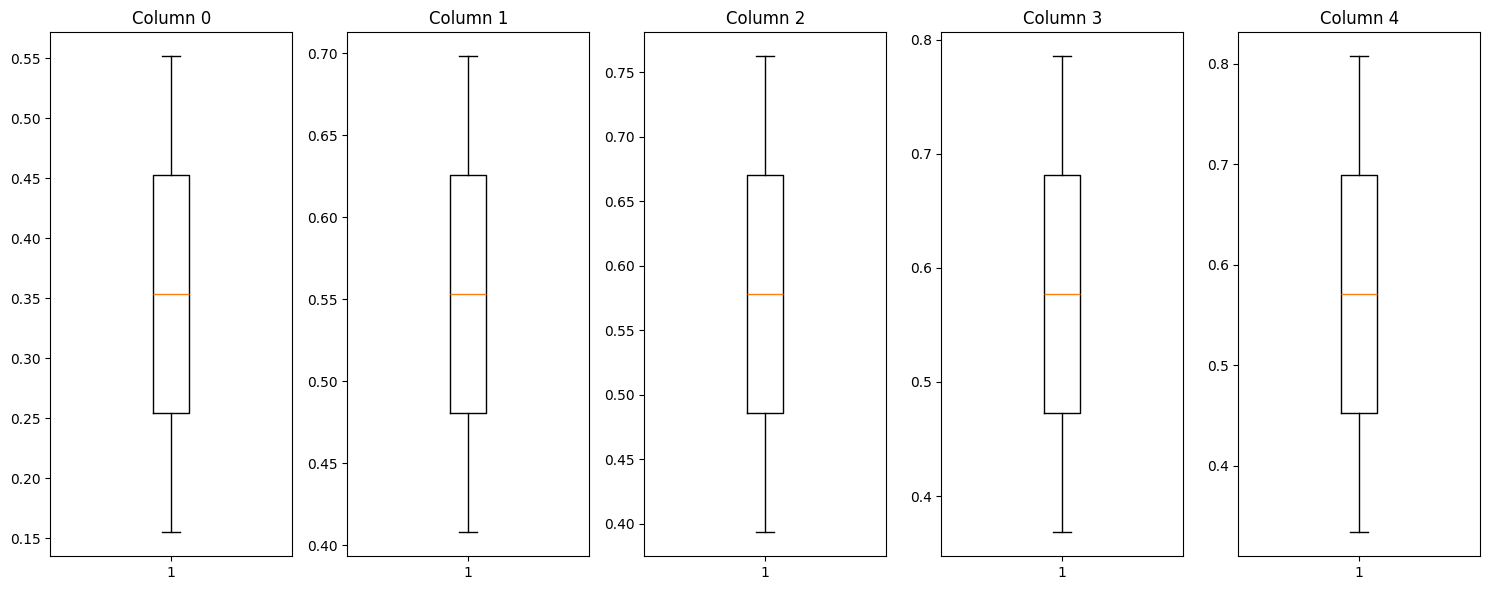

In [7]:
import matplotlib.pyplot as plt

# Visualize the distribution of the first few columns
plt.figure(figsize=(15, 6))
for i in range(min(5, dataframe.shape[1])):  # Limiting to the first 5 columns for simplicity
    plt.subplot(1, 5, i + 1)
    plt.boxplot(dataframe[i].dropna())
    plt.title(f'Column {i}')

plt.tight_layout()
plt.show()

In [8]:
# Convert data to numeric
dataframe = dataframe.apply(pd.to_numeric, errors='coerce')

In [9]:
dataframe.replace([np.inf, -np.inf], np.nan, inplace=True)
if dataframe.isnull().sum().sum() > 0:
    print("\nMissing values after replacing infinities:")
    print(dataframe.isnull().sum()[dataframe.isnull().sum() > 0])
else:
    print("\nNo missing values found after replacing infinities.")


No missing values found after replacing infinities.


In [10]:
# Cell 2: Reading the file and cleaning the data
with open(path, 'r') as file:
    lines = [line.strip() for line in file]
print('Length of lines is:', len(lines))

Length of lines is: 2


In [11]:
# Cell 3: Extract theta and phi values
with open(path, 'r') as file:
    lines = file.readlines()
    theta = [float(x) for x in lines[0].split(" ")]
    phi = [float(x) for x in lines[1].split(" ")]
video_h, video_w = 3840, 7680
fov_h, fov_w = 1080, 1920
src_resolution = [video_h, video_w]

import matplotlib.pyplot as plt

time_interval = 0.1  # Time interval in seconds
time_stamps = [i * time_interval for i in range(len(theta))]  # Generate time stamps

# Plotting
plt.figure(figsize=(8, 4))
plt.plot(time_stamps, theta, marker='.', label='Pitch Angle')
plt.xlabel('Time (seconds)')
plt.ylabel('Pitch Angle (radians)')
plt.title('Pitch Angle vs Time')
plt.grid(False)
plt.legend()     

plt.show()

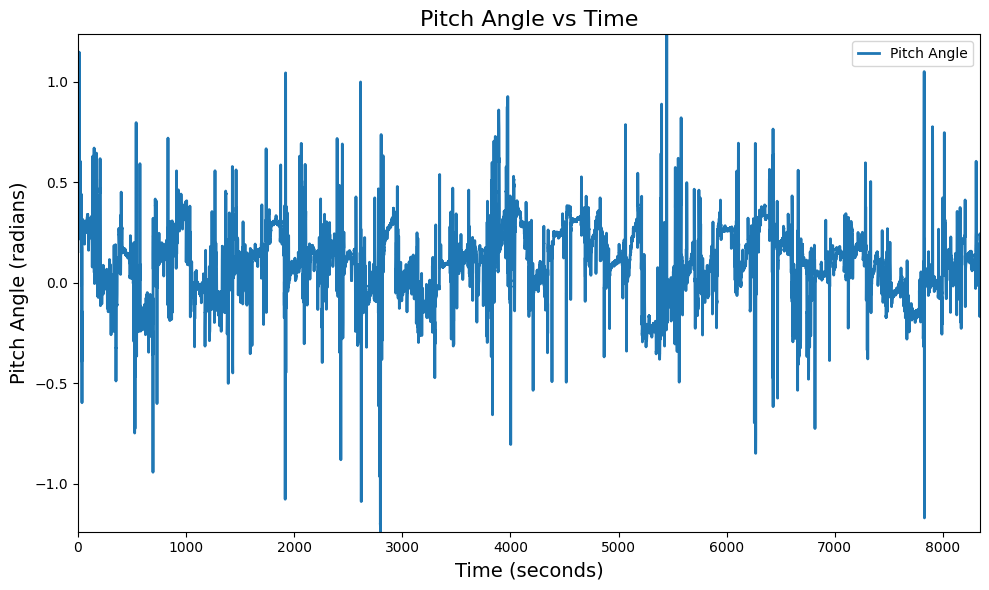

In [12]:
plt.figure(figsize=(10, 6))  # Larger figure size for clarity
time_step = 0.1  # Each time interval
time_stamps = np.arange(0, len(theta) * time_step, time_step)  # Creates time array
plt.plot(time_stamps, theta, linewidth=2, label='Pitch Angle')  # Thicker line for better visibility
plt.xlabel('Time (seconds)', fontsize=14)  
plt.ylabel('Pitch Angle (radians)', fontsize=14)
plt.title('Pitch Angle vs Time', fontsize=16)  
# Add and customize the legend
plt.legend(fontsize=10, handlelength=1.5, borderaxespad=0.5)  # Reduced font size and handle length
# Adjust x-axis and y-axis limits
plt.xlim(left=min(time_stamps), right=max(time_stamps))  # Set x-axis limits
plt.ylim(bottom=min(theta), top=max(theta))  # Set y-axis limits

plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('pitch_angle_vs_time.png', dpi=300)  # Save as high-resolution PNG
plt.show()

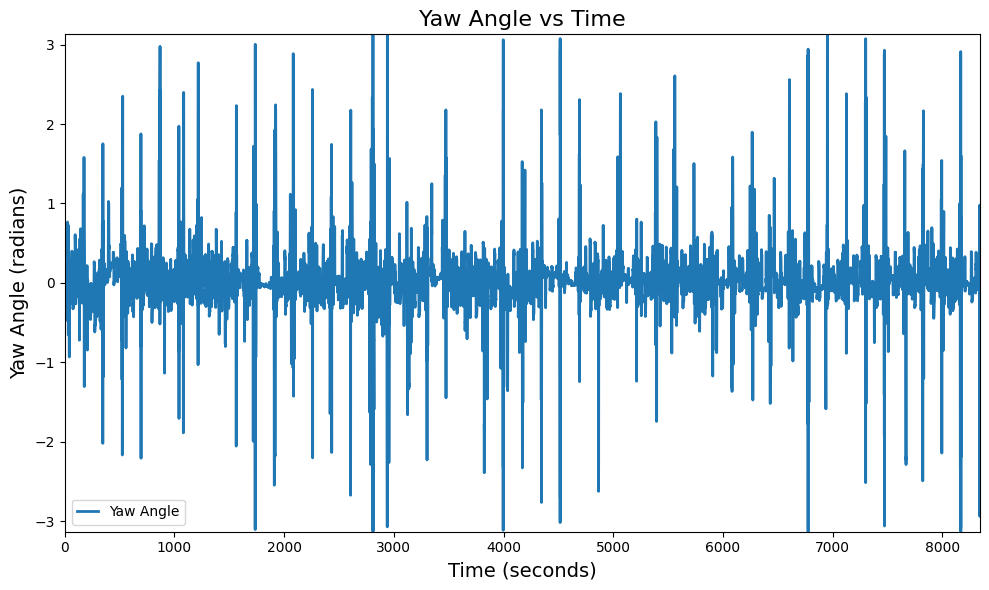

In [13]:
plt.figure(figsize=(10, 6))  # Larger figure size for clarity
plt.plot(time_stamps, phi, linewidth=2, label='Yaw Angle')  # Thicker line for better visibility
plt.xlabel('Time (seconds)', fontsize=14)  # Larger font size
plt.ylabel('Yaw Angle (radians)', fontsize=14)  # Larger font size
plt.title('Yaw Angle vs Time', fontsize=16)  # Larger and bold title

# Add and customize the legend
plt.legend(fontsize=10, handlelength=1.5, borderaxespad=0.5)  # Reduced font size and handle length

# Adjust x-axis and y-axis limits
plt.xlim(left=min(time_stamps), right=max(time_stamps))  # Set x-axis limits
plt.ylim(bottom=min(phi), top=max(phi))  # Set y-axis limits

plt.tight_layout()  # Adjust layout to prevent clipping
plt.savefig('yaw_angle_vs_time.png', dpi=300)  # Save as high-resolution PNG
plt.show()


In [14]:
# Cell 4: Convert phi and theta to polar coordinates
p = list(zip(phi, theta))
polar_coord = np.array([[phi, theta] for phi, theta in p])

In [15]:
# Cell 5: Function to convert polar coordinates to pixel coordinates in ERP format
def _3d_polar_coord_to_erp(polar_coord, src_resolution):
    erp_height, erp_width = src_resolution
    phi, theta = np.split(polar_coord, 2, axis=-1)
    phi = phi.reshape(phi.shape[:2])
    theta = theta.reshape(theta.shape[:2])
    u = phi / (2 * np.pi) + 0.5
    v = 0.5 - theta / np.pi
    coor_x = u * erp_width - 0.5
    coor_y = v * erp_height - 0.5
    coor_x = np.clip(coor_x, 0, erp_width - 1)
    coor_y = np.clip(coor_y, 0, erp_height - 1)
    pixel_coord = np.hstack([coor_x, coor_y])
    return pixel_coord

In [16]:
# Cell 6: Convert polar coordinates to pixel coordinates
pixel_coord = _3d_polar_coord_to_erp(polar_coord, src_resolution)
print("Pixel coordinates are:", pixel_coord[20:30])

# Cell 7: Calculate velocity from pixel coordinates
differences = np.diff(pixel_coord, axis=0)
dt = 0.1
vx = differences[:, 0] / dt
vy = differences[:, 1] / dt
vel = np.array([[x, y] for x, y in zip(vx, vy)])
print("Velocity (first 5):", vel[:5])

Pixel coordinates are: [[4129.27302292 1454.78850842]
 [4054.73802815 1453.21490657]
 [3958.86345712 1435.44471987]
 [3859.8416824  1438.20811823]
 [3798.73987413 1450.64341087]
 [3751.14801341 1414.60409054]
 [3710.54140967 1481.04079288]
 [3655.04315919 1510.01809517]
 [3610.82878536 1527.25095441]
 [3589.64273123 1551.89125649]]
Velocity (first 5): [[-1757.82840391 -6638.2969594 ]
 [ -181.15611499  -788.33614446]
 [ -304.74143072  -280.17788971]
 [ -419.88302923  -269.43134051]
 [ -369.22072589    49.51088736]]


In [17]:
# Cell 8: Define tiles for video frame
def tile(video_w, video_h):
    return {
        1: [(0, video_w/3), (0, video_h/3)],
        2: [(video_w/3, 2*video_w/3), (0, video_h/3)],
        3: [(2*video_w/3, video_w), (0, video_h/3)],
        4: [(0, video_w/3), (video_h/3, 2*video_h/3)],
        5: [(video_w/3, 2*video_w/3), (video_h/3, 2*video_h/3)],
        6: [(2*video_w/3, video_w), (video_h/3, 2*video_h/3)],
        7: [(0, video_w/3), (2*video_h/3, video_h)],
        8: [(video_w/3, 2*video_w/3), (2*video_h/3, video_h)],
        9: [(2*video_w/3, video_w), (2*video_h/3, video_h)],
    }

tiles = tile(video_w, video_h)

In [18]:
# Cell 9: Build rectangles around pixel coordinates
def build_rectangle(fov_w, fov_h, pixel_coord):
    a1, b1, a2, b2 = [], [], [], []
    for i in pixel_coord:
        a1.append(i[0] - fov_w / 2)
        b1.append(i[1] - fov_h / 2)
        a2.append(i[0] + fov_w / 2)
        b2.append(i[1] + fov_h / 2)
    return a1, b1, a2, b2

a1, b1, a2, b2 = build_rectangle(fov_w, fov_h, pixel_coord)

In [19]:
# Cell 10: Check for overlapping tiles
def check_overlap(a1, b1, a2, b2, pixel_coord, tiles, video_w):
    matrices, overlapping_tiles_per_iteration = [], []
    for i in range(len(pixel_coord)):
        overlapping_tiles = set()
        matrix = [[0 for _ in range(3)] for _ in range(3)]
        p1, p2 = pixel_coord[i][0], pixel_coord[i][1]
        for tile, (x_range, y_range) in tiles.items():
            x1, x2 = x_range
            y1, y2 = y_range
            if a2[i] > video_w: a2[i] -= video_w
            if a1[i] < 0: a1[i] += video_w
            if any([
                (x1 <= p1 <= x2 and y1 <= p2 <= y2),
                (x1 <= a1[i] <= x2 and y1 <= b1[i] <= y2),
                (x1 <= a1[i] <= x2 and y1 <= b2[i] <= y2),
                (x1 <= a2[i] <= x2 and y1 <= b1[i] <= y2),
                (x1 <= a2[i] <= x2 and y1 <= b2[i] <= y2)
            ]):
                overlapping_tiles.add(tile)
                matrix[(tile - 1) // 3][(tile - 1) % 3] = 1
        matrices.append(matrix)
        overlapping_tiles_per_iteration.append(overlapping_tiles)
    return matrices, overlapping_tiles_per_iteration

matrices, overlapping_tiles_per_iteration = check_overlap(a1, b1, a2, b2, pixel_coord, tiles, video_w)

In [20]:
# Cell 11: Ensure lengths match
min_length = min(len(pixel_coord), len(vel))
pixel_coord = pixel_coord[:min_length]
vel = vel[:min_length]
matrices = matrices[:min_length]

In [21]:
# Cell 12: Prepare input (X) and output (y)
X = np.array([[px[0], px[1], v[0], v[1]] for px, v in zip(pixel_coord, vel)])
y = np.array([np.concatenate(matrix) for matrix in matrices])

In [22]:
# Cell 13: Filter sequences of identical rows
filtered_X, filtered_y = [], []
current_sequence_X, current_sequence_y = [X[0]], [y[0]]

for i in range(1, len(y)):
    if np.array_equal(y[i], y[i-1]):
        current_sequence_X.append(X[i])
        current_sequence_y.append(y[i])
    else:
        if len(current_sequence_y) > 10:
            filtered_X.extend(current_sequence_X)
            filtered_y.extend(current_sequence_y)
        current_sequence_X, current_sequence_y = [X[i]], [y[i]]

if len(current_sequence_y) > 10:
    filtered_X.extend(current_sequence_X)
    filtered_y.extend(current_sequence_y)

X = np.array(filtered_X)
y = np.array(filtered_y)

In [23]:
# Cell 14: Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)
y = scaler.fit_transform(y)

In [24]:
# Cell 15: Split data for training, validation, and testing
n = len(X)
train_size = int(n * 0.7)
val_size = int(n * 0.1)
X_train, X_val, X_test = np.split(X, [train_size, train_size + val_size])
y_train, y_val, y_test = np.split(y, [train_size, train_size + val_size])

print(f"Lengths: X_Train: {len(X_train)}, X_Val: {len(X_val)}, X_Test: {len(X_test)}, y_train: {len(y_train)}, y_val: {len(y_val)}, y_Test: {len(y_test)}")
print(f"Shapes: X_Train shape: {X_train.shape}, X_Val shape: {X_val.shape}, X_Test shape: {X_test.shape}, y_train shape: {y_train.shape}, y_val shape: {y_val.shape}, y_Test shape: {y_test.shape}")

Lengths: X_Train: 52429, X_Val: 7489, X_Test: 14981, y_train: 52429, y_val: 7489, y_Test: 14981
Shapes: X_Train shape: (52429, 4), X_Val shape: (7489, 4), X_Test shape: (14981, 4), y_train shape: (52429, 9), y_val shape: (7489, 9), y_Test shape: (14981, 9)


In [25]:
# Cell 16: Create sequences for LSTM model
seq_length = 30
def create_sequences(X, seq_length, y):
    x = []
    Y = []
    for i in range(len(X) - seq_length):
        x.append(X[i:i + seq_length])
        Y.append(y[i + seq_length])
    return np.array(x), np.array(Y)

X_train_seq, y_train_seq = create_sequences(X_train, seq_length, y_train)
X_val_seq, y_val_seq = create_sequences(X_val, seq_length, y_val)
X_test_seq, y_test_seq = create_sequences(X_test, seq_length, y_test)

# Print shapes to verify
print("Shapes of sequences:", X_train_seq.shape, y_train_seq.shape, X_val_seq.shape, y_val_seq.shape, X_test_seq.shape, y_test_seq.shape)

Shapes of sequences: (52399, 30, 4) (52399, 9) (7459, 30, 4) (7459, 9) (14951, 30, 4) (14951, 9)


In [26]:
def ms_error(test_actual, test_pred):
    return tf.reduce_mean(tf.square(tf.subtract(test_actual, test_pred)), axis=1)
def ma_error(test_actual, test_pred):
    return tf.reduce_mean(tf.abs(tf.subtract(test_actual, test_pred)), axis=1)
def rms_error(test_actual, test_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(test_actual, test_pred)), axis=1))

In [27]:
# Define inp_shape based on the training data
inp_shape = (X_train_seq.shape[1], X_train_seq.shape[2])  # (sequence_length, number_of_features)

print("Input shape for the model:", inp_shape)

Input shape for the model: (30, 4)


In [28]:
from sklearn.metrics import classification_report
tf.random.set_seed(42)
model = Sequential()
model.add(LSTM(200, input_shape=(inp_shape), return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(100, return_sequences=True))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(LSTM(50, return_sequences=False))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(9, activation='sigmoid'))
# Compile model
model.compile(optimizer=Adam(learning_rate=0.0001), loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# Train model
history = model.fit(X_train_seq, y_train_seq, epochs=100, batch_size=64, validation_data= (X_val_seq, y_val_seq), callbacks=[early_stopping])
# Predict and evaluate
y_pred = np.round(model.predict(X_test_seq))
print("Classification Report:\n", classification_report(y_test_seq, y_pred))
test_actual = y_test_seq
test_pred = y_pred

Epoch 1/100
819/819 [==============================] - 335s 391ms/step - loss: 0.2104 - val_loss: 0.0872
Epoch 2/100
819/819 [==============================] - 339s 414ms/step - loss: 0.1218 - val_loss: 0.0619
Epoch 3/100
819/819 [==============================] - 330s 402ms/step - loss: 0.0800 - val_loss: 0.0439
Epoch 4/100
819/819 [==============================] - 632s 772ms/step - loss: 0.0544 - val_loss: 0.0305
Epoch 5/100
819/819 [==============================] - 325s 397ms/step - loss: 0.0373 - val_loss: 0.0199
Epoch 6/100
819/819 [==============================] - 316s 386ms/step - loss: 0.0278 - val_loss: 0.0265
Epoch 7/100
819/819 [==============================] - 323s 394ms/step - loss: 0.0239 - val_loss: 0.0286
Epoch 8/100
819/819 [==============================] - 326s 398ms/step - loss: 0.0213 - val_loss: 0.0174
Epoch 9/100
819/819 [==============================] - 318s 388ms/step - loss: 0.0196 - val_loss: 0.0324
Epoch 10/100
819/819 [==============================] -

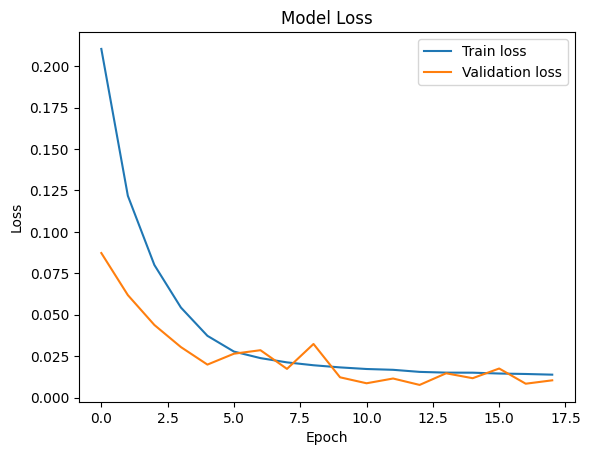

In [29]:
# graph plotting
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Validation loss'], loc = 'upper right')
plt.show()

In [30]:
# Print the actual and predicted output vectors in 2 columns
print("Y Test actual:\t\tY Test predicted:")
for actual, predicted in zip(test_actual, test_pred):
    print(f"{actual}\t\t{predicted}")

# Save the actual and predicted output vectors to a file
#output_file = 'output_vectors.txt'
#with open(output_file, 'w') as f:
 #   f.write("Y Test actual\tY Test predicted\n")
  #  for actual, predicted in zip(test_actual, test_pred):
   #     f.write(f"{actual}\t{predicted}\n")

#print(f"Results saved to '{output_file}'.")
print(f"Length of actual test matrices: {len(test_actual)}, Predicted test matrices: {len(test_pred)}")

#with open('test_actual.txt', 'w') as f:
 #   for item in test_actual:
  #      f.write(f"{item}\n")

# Save the predicted output vectors to a file
#with open('test_pred.txt', 'w') as f:
 #   for item in test_pred:
  #      f.write(f"{item}\n")

Y Test actual:		Y Test predicted:
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 0. 0.]		[0. 1. 0. 0. 1. 0. 0. 0. 0.]
[0. 1. 0. 0. 1. 0. 0. 

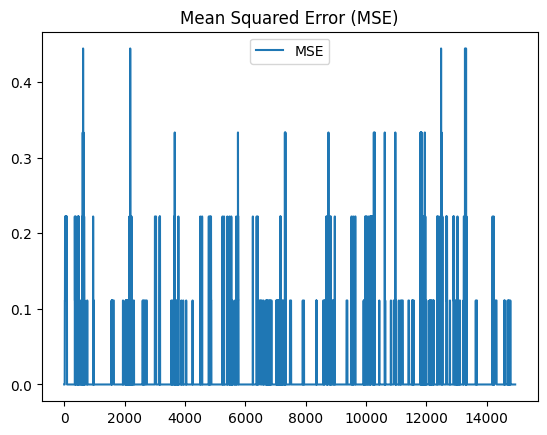

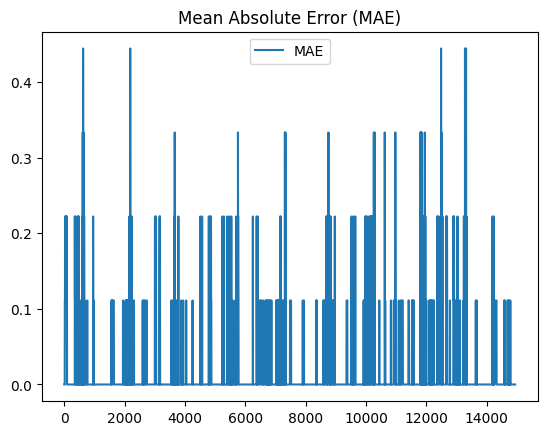

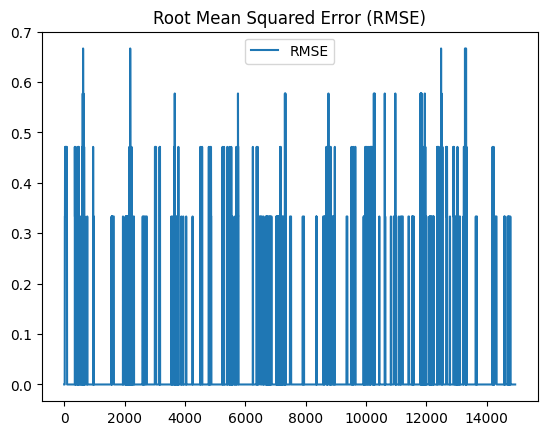

In [31]:
# Plot MSE, MAE, RMSE for LSTM model
mse = ms_error(test_actual, test_pred).numpy()
mae = ma_error(test_actual, test_pred).numpy()
rmse = rms_error(test_actual, test_pred).numpy()

plt.figure()
plt.plot(mse, label='MSE')
plt.title('Mean Squared Error (MSE)')
plt.legend()
plt.show()

plt.figure()
plt.plot(mae, label='MAE')
plt.title('Mean Absolute Error (MAE)')
plt.legend()
plt.show()

plt.figure()
plt.plot(rmse, label='RMSE')
plt.title('Root Mean Squared Error (RMSE)')
plt.legend()
plt.show()

In [32]:
## accuracy levels comparison (100%, 75%, 50%, 25%, 0%)
def compare_vectors(test_actual, test_pred):
    accuracy_levels = Counter()
    comparison = np.equal(test_actual, test_pred).all(axis=1)
    num_ones = np.sum(comparison)
    num_zeros = len(comparison) - num_ones
    print('comparison:', comparison.astype(int))
    print('No. of ones:', num_ones)
    print('No. of zeros:', num_zeros)
    for a, b in zip(test_actual, test_pred):
        count = sum(x == y == 1 for x, y in zip(a, b))
        total = sum(a)
        accuracy = (count / total) * 100 if total != 0 else 0
        level = min(int(math.floor(accuracy / 25)) * 25, 100)
        accuracy_levels[level] += 1
        overall_accuracy = (num_ones / len(test_actual)) * 100

    print('Overall Accuracy (100% match):', overall_accuracy)
    return accuracy_levels, overall_accuracy
print(compare_vectors(test_actual, test_pred))

comparison: [1 1 1 ... 1 1 1]
No. of ones: 13201
No. of zeros: 1750
Overall Accuracy (100% match): 88.29509731790516
(Counter({100: 14205, 50: 634, 75: 81, 25: 31}), 88.29509731790516)
